In [13]:
import pandas as pd
import re
from sqlalchemy import create_engine
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

source_db_connection_string = 'mssql+pyodbc://@DESKTOP-QHDNCIS\SQLEXPRESS/customers?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes'

target_db_connection_string = 'mssql+pyodbc://@./customers?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes'

# Extract data from source database
def extract_data(query):
    source_engine = create_engine(source_db_connection_string)
    data = pd.read_sql(query, source_engine)
    return data

# SQL query to extract feedback data
query = "SELECT * FROM Feedback"
data = extract_data(query)

#Data Cleaning and Transformation including Text Preprocessing
def transform_data(data):
    # remove duplicates
    data.drop_duplicates(inplace=True)
    
    # Convert 'date' column to datetime
    if 'date' in data.columns:
        data['date'] = pd.to_datetime(data['date'], errors='coerce')
    
    # Remove rows with null values in important columns
    data.dropna(subset=['Comments', 'Rating'], inplace=True)
    
    # Create a new column that calculates the length of the feedback text
    data['feedback_length'] = data['Comments'].apply(lambda x: len(str(x)))

    # Initialize the NLTK stopwords list and lemmatizer
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Text Preprocessing
    def preprocess_text(text):
        # 1. Lowercase the text
        text = str(text).lower()
        
        # 2. Remove special characters and numbers
        text = re.sub(r'[^\w\s]', '', text)
        
        # 3. Tokenize the text into words
        words = text.split()
        
        # 4. Remove stopwords
        words = [word for word in words if word not in stop_words]
        
        # 5. Lemmatize each word
        words = [lemmatizer.lemmatize(word) for word in words]
        
        # 6. Rejoin the words into a cleaned string
        return ' '.join(words)

    # Apply the text preprocessing function to the 'feedback' column
    data['cleaned_feedback'] = data['Comments'].apply(preprocess_text)
    
    return data


# Apply the transformation to the  data
transformed_data = transform_data(data)

# Preview the transformed data
print(transformed_data[['Comments', 'cleaned_feedback']])


                                              Comments  \
0    The product quality is excellent, I am very sa...   
1    Customer service was good, but there was a sli...   
2    Delivery took longer than expected, but arrive...   
3    Good product quality, but there’s room for imp...   
4          Customer service was not responsive enough.   
..                                                 ...   
115              Service was good but not outstanding.   
116             Delivery was average, no major issues.   
117  Satisfied with the product, but there’s room f...   
118           Customer service was not helpful at all.   
119  The delivery was quick and the product arrived...   

                                 cleaned_feedback  
0             product quality excellent satisfied  
1              customer service good slight delay  
2    delivery took longer expected arrived safely  
3     good product quality there room improvement  
4              customer service responsive 

In [1]:
def label_sentiment(row):
    if row['Rating'] >= 4:
        return 'Positive'
    elif row['Rating'] == 3:
        return 'Neutral'
    else:
        return 'Negative'

transformed_data['Sentiment'] = transformed_data.apply(label_sentiment, axis=1)
print(transformed_data['Sentiment'].value_counts())#check number of each type


NameError: name 'transformed_data' is not defined

In [3]:
from sklearn.model_selection import train_test_split

X = transformed_data['cleaned_feedback']  
y = transformed_data['Sentiment'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000) #transform text to numbers

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Logistic Regression model
model1 = LogisticRegression()
model1.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model1.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))#evalute the model

Accuracy: 0.7916666666666666


In [7]:
#Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred_nb))

Accuracy: 0.75


In [8]:
# SVM Model
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

Accuracy: 0.8333333333333334


In [9]:
# Random Forest Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Accuracy: 0.75


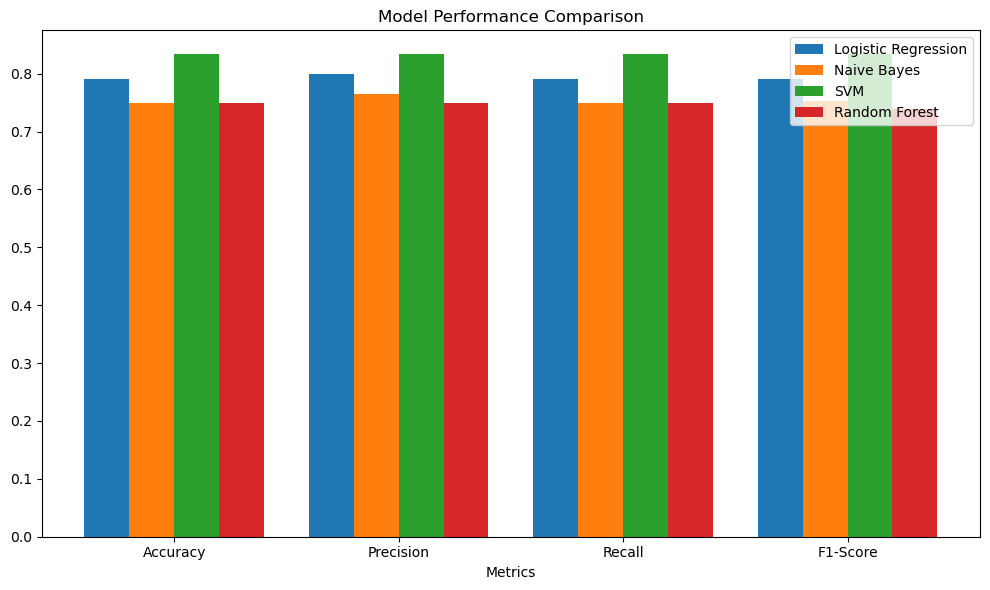

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Model Performance Metrics Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Model Performance Metrics Data
data = {
    'Model': ['Logistic Regression', 'Naive Bayes', 'SVM', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred), 
        accuracy_score(y_test, y_pred_nb), 
        accuracy_score(y_test, y_pred_svm), 
        accuracy_score(y_test, y_pred_rf)
    ],
    'Precision': [
        precision_score(y_test, y_pred, average='weighted'), 
        precision_score(y_test, y_pred_nb, average='weighted'),
        precision_score(y_test, y_pred_svm, average='weighted'), 
        precision_score(y_test, y_pred_rf, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred, average='weighted'),
        recall_score(y_test, y_pred_nb, average='weighted'), 
        recall_score(y_test, y_pred_svm, average='weighted'), 
        recall_score(y_test, y_pred_rf, average='weighted')
    ],
    'F1-Score': [
        f1_score(y_test, y_pred, average='weighted'),
        f1_score(y_test, y_pred_nb, average='weighted'), 
        f1_score(y_test, y_pred_svm, average='weighted'), 
        f1_score(y_test, y_pred_rf, average='weighted')
    ]
}

df = pd.DataFrame(data)


metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))  
width = 0.2  

fig, ax = plt.subplots(figsize=(10, 6))

for i, model in enumerate(df['Model']):
    ax.bar(x + i*width, df.loc[i, metrics], width, label=model)


ax.set_xlabel('Metrics')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics)
ax.legend()
#show lot
plt.tight_layout()
plt.show()


In [12]:
df

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.791667,0.800000,0.791667,0.791092
1,Naive Bayes,0.750000,0.765625,0.750000,0.752778
2,SVM,0.833333,0.833333,0.833333,0.833333
3,Random Forest,0.750000,0.750000,0.750000,0.739583
